In [1]:
from get_data import get_data
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras import callbacks
from plot_loss import *
import numpy as np

1.9.0


Using TensorFlow backend.


In [2]:
answers, answers_int, answers_int_to_vocab, questions, questions_int, questions_int_to_vocab = get_data()

18162
18162
# of questions: 10795
# of answers: 10795
% of data used: 59.440000000000005%
Size of total vocab: 10335
Size of vocab we will use: 1300
1304
1304
1304
1304
10795
10795
Total number of words: 141599
Number of times <UNK> is used: 22354
Percent of words that are <UNK>: 15.79%
10795
10795

[17, 18]
[65, 228, 1302]

[48, 49]
[50, 38, 1302]

[50, 38]
[12, 1303, 41, 51, 52, 31, 1303, 1302]



In [3]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = int(len(answers) * 0.75)

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

lines = [q+'\t'+a for q, a in zip(questions, answers)]

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)


In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 8096
Number of unique input tokens: 43
Number of unique output tokens: 49
Max sequence length for inputs: 164
Max sequence length for outputs: 136


In [6]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.


In [7]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


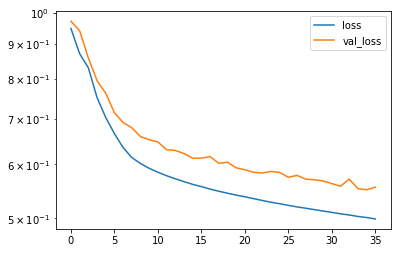


Epoch 00036: val_loss did not improve from 0.55071
Epoch 37/100
5632/6476 [=========================>....] - ETA: 1:07 - loss: 0.4985

In [ ]:
# Run training
model.compile(optimizer='adadelta', loss='categorical_crossentropy')

plot_loss = PlotLearning()
checkpoint = callbacks.ModelCheckpoint("models/{epoch:02d}.hdf5", verbose=1, save_best_only=True)

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, callbacks=[plot_loss, checkpoint],
          epochs=epochs,
          validation_split=0.2)

In [ ]:
model = load_model('models/96.hdf5')

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


In [ ]:
def chat_with_bot(input_text='hallo kobold'):
    encoded_input_data = np.zeros((len(input_text), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for i, test in enumerate(input_text):
        for t, char in enumerate(test):
            encoded_input_data[i, t, input_token_index[char]] = 1.
    decoded_sentence = decode_sequence(encoded_input_data)
    print('-')
    print('Input sentence:', input_text)
    print('Decoded sentence:', decoded_sentence)

chat_with_bot()